In [2]:
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsbombpy import sb
from mplsoccer import Pitch

In [3]:
base_path = '/Users/derekchui/Documents/Programming/Personal/Projects/Analytics/open-data/data'
matches_path = os.path.join(base_path, 'matches', '43', '106.json')  #CHANGE WORLD CUP
events_dir = os.path.join(base_path, 'events')
with open(matches_path, 'r', encoding='utf-8') as f:
    matches = json.load(f)
matches_df = pd.json_normalize(matches)
display(matches_df[['match_id', 'home_team.home_team_name', 'away_team.away_team_name', 'match_date']])

,match_id,home_team.home_team_name,away_team.away_team_name,match_date
0,3857256,Serbia,Switzerland,2022-12-02
1,3869151,Argentina,Australia,2022-12-03
2,3857257,Australia,Denmark,2022-11-30
3,3857258,Brazil,Serbia,2022-11-24
4,3857288,Tunisia,Australia,2022-11-26
...,...,...,...,...
59,3857265,Mexico,Poland,2022-11-22
60,3857262,South Korea,Portugal,2022-12-02
61,3857261,Wales,England,2022-11-29
62,3857255,Japan,Spain,2022-12-01


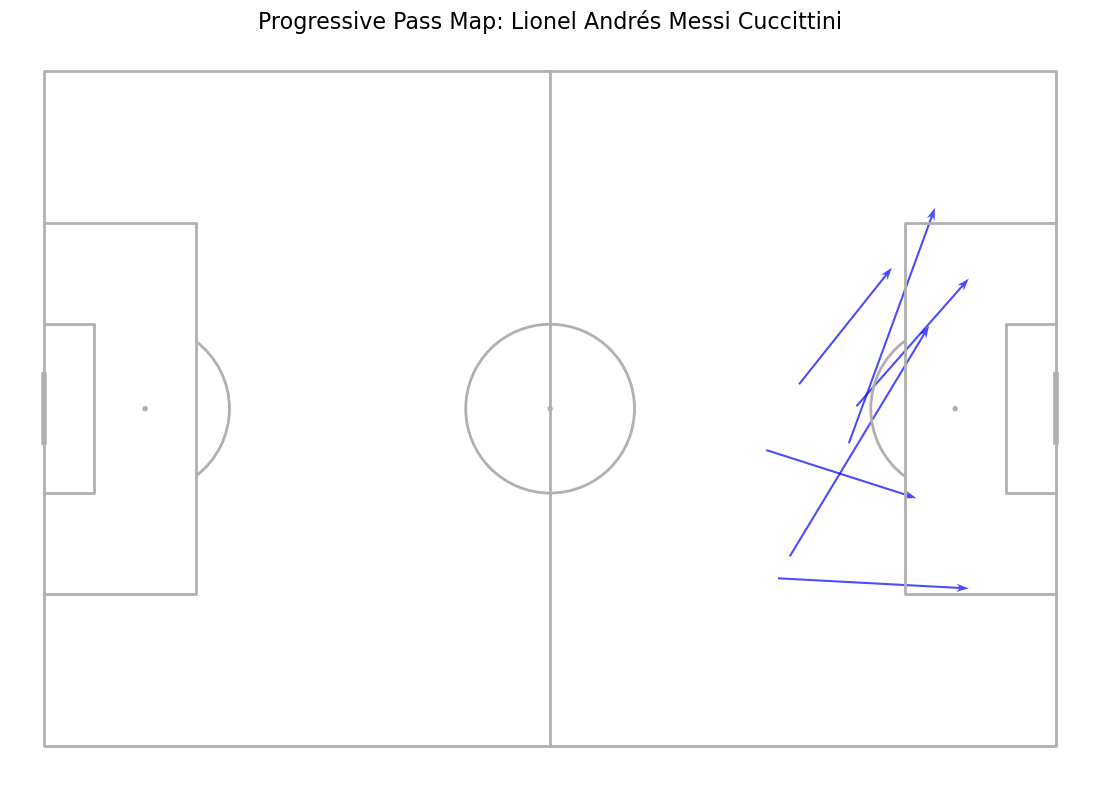

In [5]:
match_id = matches_df.iloc[6]['match_id'] #CHANGE INDEX FOR DIFFERENT GAME. 0 = Serbia v Switzerland.
event_file = os.path.join(events_dir, f"{match_id}.json")
with open(event_file, 'r', encoding='utf-8') as f:
    events = json.load(f)
events_df = pd.json_normalize(events)
subs = events_df[events_df['type.name'] == 'Substitution']
tactical = events_df[events_df['type.name'] == 'Tactical Shift']
shots = events_df[events_df['type.name'] == 'Shot']
subs = subs[['timestamp', 'minute', 'second', 'team.name', 'player.name', 'substitution.replacement.name']]
tactical = tactical[['timestamp', 'minute', 'second', 'team.name', 'tactics.formation']]
shots = shots[['timestamp', 'minute', 'second', 'team.name', 'player.name', 'shot.statsbomb_xg']]
passes = events_df[events_df['type.name'] == 'Pass'].copy()
passes['x_start'] = passes['location'].apply(lambda x: x[0] if isinstance(x, list) else None)
passes['x_end'] = passes['pass.end_location'].apply(lambda x: x[0] if isinstance(x, list) else None)
passes['x_gain'] = passes['x_end'] - passes['x_start']
passes['progressive'] = (
    ((passes['x_start'] < 60) & (passes['x_end'] - passes['x_start'] >= 25)) |  # From own half
    ((passes['x_start'] >= 60) & (passes['x_end'] - passes['x_start'] >= 10))   # From opp half
)
prog_passes = passes[(passes['progressive'] == True) & (passes['pass.outcome.name'].isna())]
pitch = Pitch(pitch_type='statsbomb', line_zorder=2)
fig, ax = pitch.draw(figsize=(12, 8))
player_prog = prog_passes[prog_passes['player.name'] == 'Lionel Andrés Messi Cuccittini']
for _, row in player_prog.iterrows():
    if isinstance(row['location'], list) and isinstance(row['pass.end_location'], list):
        x0, y0 = row['location']
        x1, y1 = row['pass.end_location']
        pitch.arrows(x0, y0, x1, y1, ax=ax,
                     color='blue', width=1.5, headwidth=4, headlength=6, alpha=0.7)
# Step 4: Add title safely
if not player_prog.empty:
    plt.title(f"Progressive Pass Map: {player_prog.iloc[0]['player.name']}", fontsize=16)
else:
    plt.title("No progressive passes found for this player.", fontsize=14)
plt.show()

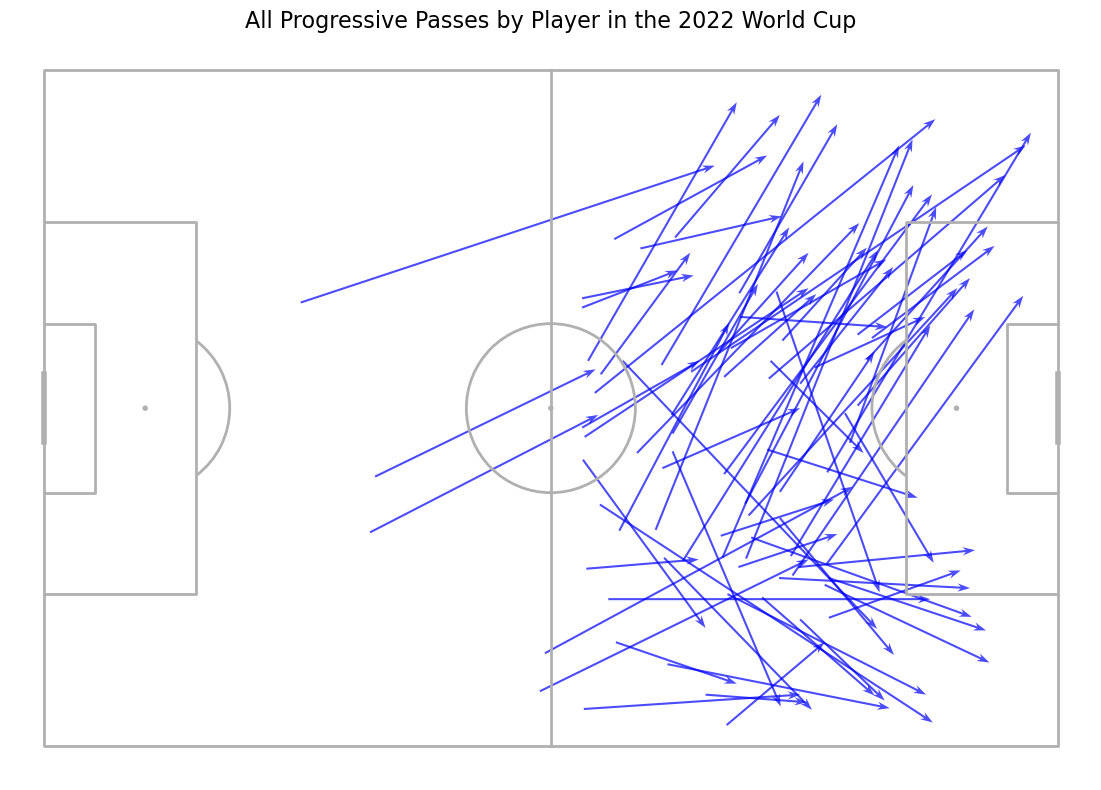

In [6]:
playerName = 'Lionel Andrés Messi Cuccittini'
playerPasses = []
for _, match in matches_df.iterrows():
    match_id = match['match_id']
    if match['home_team.home_team_name'] != 'Argentina' and match['away_team.away_team_name'] != 'Argentina':
        continue
    event_path = os.path.join(events_dir, f"{match_id}.json")
    if not os.path.exists(event_path):
        continue
    with open(event_path, 'r', encoding='utf-8') as f:
        events = json.load(f)
    events_df = pd.json_normalize(events)
    passes = events_df[events_df['type.name'] == 'Pass'].copy()
    passes['x_start'] = passes['location'].apply(lambda x: x[0] if isinstance(x, list) else None)
    passes['x_end'] = passes['pass.end_location'].apply(lambda x: x[0] if isinstance(x, list) else None)
    passes['x_gain'] = passes['x_end'] - passes['x_start']

    passes['progressive'] = (
        ((passes['x_start'] < 60) & (passes['x_gain'] >= 25)) |
        ((passes['x_start'] >= 60) & (passes['x_gain'] >= 10))
    )
    prog_passes = passes[
        (passes['progressive']) &
        (passes['pass.outcome.name'].isna()) &  # Successful
        (passes['player.name'] == playerName)
    ]
    playerPasses.append(prog_passes)
player_prog_df = pd.concat(playerPasses, ignore_index=True)
pitch = Pitch(pitch_type='statsbomb', line_zorder=2)
fig, ax = pitch.draw(figsize=(12, 8))
for _, row in player_prog_df.iterrows():
    if isinstance(row['location'], list) and isinstance(row['pass.end_location'], list):
        x0, y0 = row['location']
        x1, y1 = row['pass.end_location']
        pitch.arrows(x0, y0, x1, y1, ax=ax,
                     color='blue', width=1.5, headwidth=4, headlength=6, alpha=0.7)
plt.title("All Progressive Passes by Player in the 2022 World Cup", fontsize=16)
plt.show()

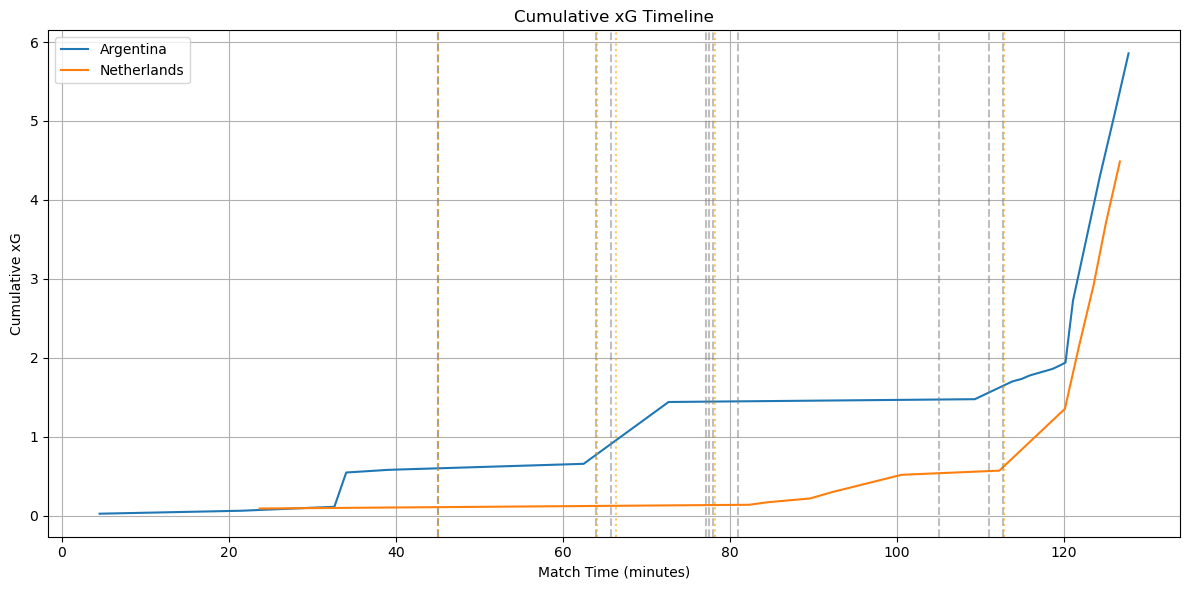

🔁 Substitutions:


,minute,second,team.name,player.name,substitution.replacement.name
1905,45,0,Netherlands,Steven Bergwijn,Steven Berghuis
1906,45,0,Netherlands,Marten de Roon,Teun Koopmeiners
2762,64,1,Netherlands,Daley Blind,Luuk de Jong
2820,65,47,Argentina,Rodrigo Javier De Paul,Leandro Daniel Paredes
3084,77,9,Argentina,Marcos Javier Acuña,Nicolás Alejandro Tagliafico
3085,77,28,Argentina,Cristian Gabriel Romero,Germán Alejandro Pezzella
3086,77,57,Netherlands,Memphis Depay,Wout Weghorst
3173,80,55,Argentina,Julián Álvarez,Lautaro Javier Martínez
4165,105,0,Argentina,Nahuel Molina Lucero,Gonzalo Ariel Montiel
4351,111,1,Argentina,Lisandro Martínez,Ángel Fabián Di María Hernández



🧠 Tactical Shifts:


,minute,second,team.name,tactics.formation
1907,45,0,Netherlands,3412.0
2763,64,4,Netherlands,4231.0
2839,66,21,Argentina,352.0
3088,78,9,Netherlands,442.0
4366,112,50,Argentina,433.0


In [7]:
shots['time_minute'] = shots['minute'] + shots['second'] / 60
shots = shots.sort_values(by='time_minute')
shots['cumulative_xg'] = shots.groupby('team.name')['shot.statsbomb_xg'].cumsum()
plt.figure(figsize=(12, 6))
teams = shots['team.name'].unique()
for team in teams:
    team_shots = shots[shots['team.name'] == team]
    plt.plot(team_shots['time_minute'], team_shots['cumulative_xg'], label=team)
for t in subs['minute'] + subs['second'] / 60:
    plt.axvline(x=t, color='gray', linestyle='--', alpha=0.5)
for t in tactical['minute'] + tactical['second'] / 60:
    plt.axvline(x=t, color='orange', linestyle=':', alpha=0.6)
plt.title('Cumulative xG Timeline')
plt.xlabel('Match Time (minutes)')
plt.ylabel('Cumulative xG')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("🔁 Substitutions:")
display(subs[['minute', 'second', 'team.name', 'player.name', 'substitution.replacement.name']])
print("\n🧠 Tactical Shifts:")
display(tactical[['minute', 'second', 'team.name', 'tactics.formation']])

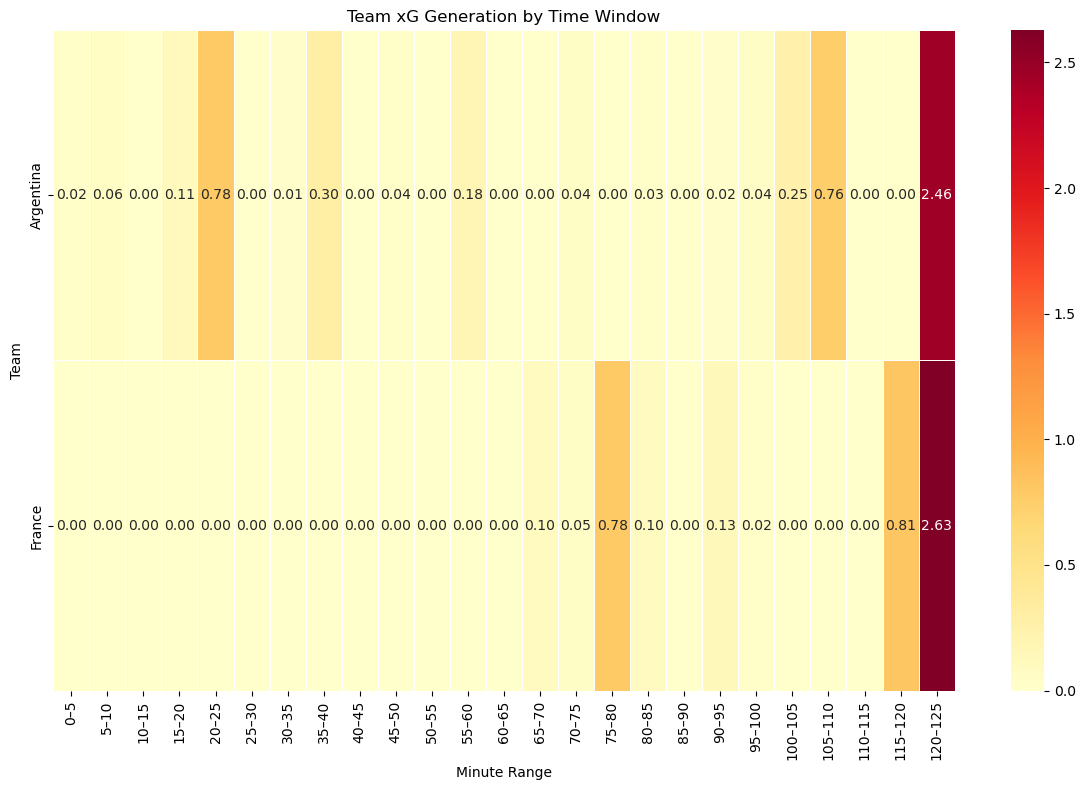

In [74]:
bins = list(range(0, 125 + 1, 5))
labels = [f'{bins[i]}–{bins[i+1]}' for i in range(len(bins)-1)]
shots['time_float'] = shots['minute'] + shots['second'] / 60
shots['time_bin'] = pd.cut(shots['time_float'], bins=bins, labels=labels, right=False)
xg_by_time = shots.groupby(['team.name', 'time_bin'], observed=False)['shot.statsbomb_xg'].sum().unstack().fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(xg_by_time, cmap='YlOrRd', linewidths=0.5, annot=True, fmt=".2f")
plt.title('Team xG Generation by Time Window')
plt.xlabel('Minute Range')
plt.ylabel('Team')
plt.tight_layout()
plt.show()

In [9]:
# Prepare a results list
sub_impact = []

# Convert shot times to float
shots['time_float'] = shots['minute'] + shots['second'] / 60

# Loop through each substitution
for _, row in subs.iterrows():
    sub_time = row['minute'] + row['second'] / 60
    team = row['team.name']
    sub_name = row['substitution.replacement.name']
    
    # Filter shots by team
    team_shots = shots[shots['team.name'] == team]

    # xG before and after this sub
    xg_before = team_shots[team_shots['time_float'] < sub_time]['shot.statsbomb_xg'].sum()
    xg_after  = team_shots[team_shots['time_float'] >= sub_time]['shot.statsbomb_xg'].sum()

    sub_impact.append({
        'Team': team,
        'Subbed On': sub_name,
        'Time (min)': round(sub_time, 1),
        'xG Before': round(xg_before, 3),
        'xG After': round(xg_after, 3)
    })

# Show results
impact_df = pd.DataFrame(sub_impact)
display(impact_df)


,Team,Subbed On,Time (min),xG Before,xG After
0,Netherlands,Steven Berghuis,45.0,0.090,4.398
1,Netherlands,Teun Koopmeiners,45.0,0.090,4.398
2,Netherlands,Luuk de Jong,64.0,0.090,4.398
3,Argentina,Leandro Daniel Paredes,65.8,0.656,5.201
4,Argentina,Nicolás Alejandro Tagliafico,77.2,1.439,4.417
5,Argentina,Germán Alejandro Pezzella,77.5,1.439,4.417
6,Netherlands,Wout Weghorst,78.0,0.090,4.398
7,Argentina,Lautaro Javier Martínez,80.9,1.439,4.417
8,Argentina,Gonzalo Ariel Montiel,105.0,1.439,4.417
9,Argentina,Ángel Fabián Di María Hernández,111.0,1.475,4.382


In [10]:
manager_impacts = []

for _, match in matches_df.iterrows():
    match_id = match['match_id']
    team_home = match['home_team.home_team_name']
    team_away = match['away_team.away_team_name']
    home_manager = match['home_team.managers'][0]['name'] if match['home_team.managers'] else 'Unknown'
    away_manager = match['away_team.managers'][0]['name'] if match['away_team.managers'] else 'Unknown'

    try:
        with open(os.path.join(events_dir, f"{match_id}.json"), 'r', encoding='utf-8') as f:
            events = json.load(f)
    except FileNotFoundError:
        continue  # skip if missing

    events_df = pd.json_normalize(events)
    if 'type.name' not in events_df.columns:
        continue

    shots = events_df[events_df['type.name'] == 'Shot'].copy()
    shots['time_float'] = shots['minute'] + shots['second'] / 60

    subs = events_df[events_df['type.name'] == 'Substitution'].copy()

    for _, row in subs.iterrows():
        sub_time = row['minute'] + row['second'] / 60
        team = row['team.name']
        subbed_on = row.get('substitution.replacement.name', 'Unknown')

        manager = home_manager if team == team_home else away_manager
        team_shots = shots[shots['team.name'] == team]
        xg_before = team_shots[team_shots['time_float'] < sub_time]['shot.statsbomb_xg'].sum()
        xg_after = team_shots[team_shots['time_float'] >= sub_time]['shot.statsbomb_xg'].sum()

        manager_impacts.append({
            'Manager': manager,
            'Team': team,
            'Subbed On': subbed_on,
            'Sub Time': round(sub_time, 1),
            'xG Before': round(xg_before, 3),
            'xG After': round(xg_after, 3),
            'Δ xG': round(xg_after - xg_before, 3),
            'Match ID': match_id
        })


In [11]:
manager_df = pd.DataFrame(manager_impacts)

summary = manager_df.groupby('Manager').agg(
    Matches=('Match ID', 'nunique'),
    Subs=('Subbed On', 'count'),
    Avg_ΔxG=('Δ xG', 'mean'),
    Total_ΔxG=('Δ xG', 'sum'),
    Positive_Subs=('Δ xG', lambda x: (x > 0).sum())
).sort_values('Total_ΔxG', ascending=False)

display(summary)


,Matches,Subs,Avg_ΔxG,Total_ΔxG,Positive_Subs
Manager,,,,,
Zlatko Dalić,7,32,0.682125,21.828,16
Hoalid Regragui,4,21,0.899476,18.889,11
Lionel Sebastián Scaloni,7,36,0.463139,16.673,20
Hajime Moriyasu,4,20,0.738300,14.766,13
Didier Deschamps,7,28,0.433250,12.131,13
Louis van Gaal,5,23,0.441696,10.159,10
Telê Santana da Silva,2,10,0.808900,8.089,5
Carlos Manuel Brito Leal Queiróz,3,16,0.453125,7.250,11
Luis Enrique Martínez García,4,20,0.275300,5.506,7


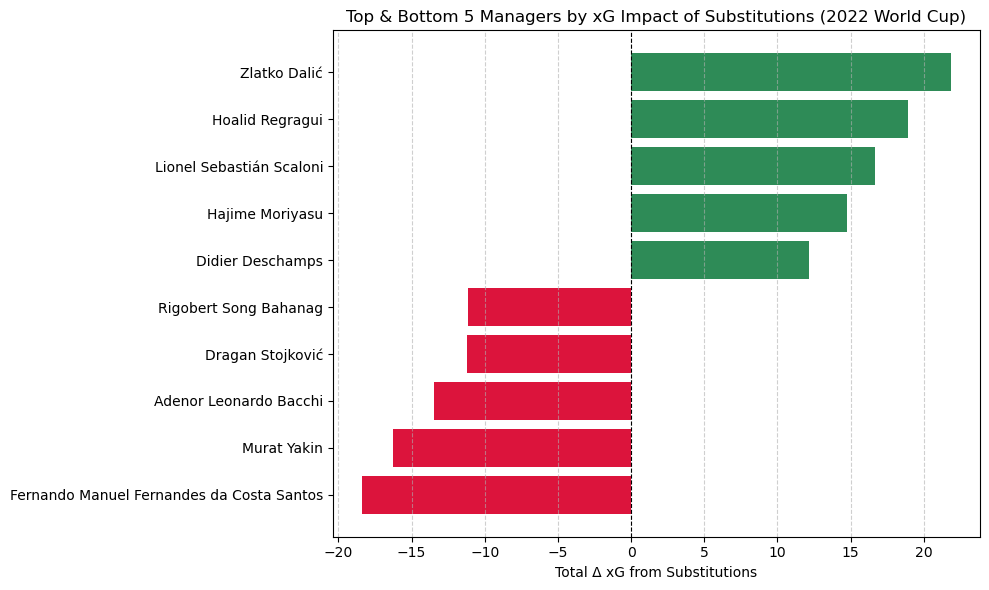

In [14]:
top5 = summary.sort_values('Total_ΔxG', ascending=False).head(5)
bottom5 = summary.sort_values('Total_ΔxG', ascending=True).head(5)
combined = pd.concat([top5, bottom5])
combined = combined.sort_values('Total_ΔxG')  # To plot from worst to best
colors = ['crimson' if val < 0 else 'seagreen' for val in combined['Total_ΔxG']]
plt.figure(figsize=(10, 6))
plt.barh(combined.index, combined['Total_ΔxG'], color=colors)
plt.xlabel('Total Δ xG from Substitutions')
plt.title('Top & Bottom 5 Managers by xG Impact of Substitutions (2022 World Cup)')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [58]:
# Show every sub by a specific manager
scaloni_subs = manager_df[manager_df['Manager'] == 'Lionel Sebastián Scaloni']
display(scaloni_subs[['Match ID', 'Team', 'Subbed On', 'Sub Time', 'xG Before', 'xG After', 'Δ xG']])


,Match ID,Team,Subbed On,Sub Time,xG Before,xG After,Δ xG
9,3869151,Argentina,Lisandro Martínez,49.1,0.078,1.404,1.326
12,3869151,Argentina,Lautaro Javier Martínez,71.0,0.436,1.045,0.609
13,3869151,Argentina,Nicolás Alejandro Tagliafico,71.3,0.436,1.045,0.609
17,3869151,Argentina,Exequiel Alejandro Palacios,79.2,0.488,0.993,0.505
18,3869151,Argentina,Gonzalo Ariel Montiel,79.3,0.488,0.993,0.505
57,3869321,Argentina,Leandro Daniel Paredes,65.8,0.656,5.201,4.545
58,3869321,Argentina,Nicolás Alejandro Tagliafico,77.2,1.439,4.417,2.978
59,3869321,Argentina,Germán Alejandro Pezzella,77.5,1.439,4.417,2.978
61,3869321,Argentina,Lautaro Javier Martínez,80.9,1.439,4.417,2.978
62,3869321,Argentina,Gonzalo Ariel Montiel,105.0,1.439,4.417,2.978
